In [62]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import mne
import warnings
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import random

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("WARNING")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [34]:
class EEG_Model(nn.Module):
    def __init__(self):
        super(EEG_Model, self).__init__()
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        
        # LSTM layers for temporal modeling
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(64, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 5)
    
    def forward(self, x):
        # CNN feature extraction
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Reshape for LSTM: [batch_size, time_steps, features]
        x = x.transpose(1, 2)
        
        # LSTM temporal modeling
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Take output from last timestep
        x = x[:, -1, :]
        
        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

In [35]:
# Sleep stage to class mapping
LABEL_MAP = {
    "Sleep stage W": 0,    # Wake
    "Sleep stage 1": 1,    # N1 (Light sleep)
    "Sleep stage 2": 2,    # N2 (Light sleep)
    "Sleep stage 3": 3,    # N3 (Deep sleep)
    "Sleep stage 4": 3,    # N4 -> N3 (combined deep sleep)
    "Sleep stage R": 4     # REM sleep
}

In [36]:
def preprocess_data(data_dir, epoch_duration=30, sfreq=100):
    """
    Preprocesses EEG data from the Sleep-EDF dataset.
    
    Args:
        data_dir (str): Path to your Sleep-EDF dataset folder
        epoch_duration (int): Duration of each epoch in seconds (default: 30)
        sfreq (int): Target sampling frequency (default: 100 Hz)
    
    Returns:
        tuple: (X, y) where X is EEG data and y is sleep stage labels
    """
    # Create arrays for data
    X_list = []
    y_list = []

    # Process all PSG.edf files in the directory
    for file in os.listdir(data_dir):
        if not file.endswith("PSG.edf"):
            continue  

        psg_path = os.path.join(data_dir, file)

        # Get base ID (e.g., 'SC4001')
        base_id = file[:6]

        # Find corresponding hypnogram file
        hypnogram_candidates = [f for f in os.listdir(data_dir)
                                if f.startswith(base_id) and "Hypnogram" in f]

        if not hypnogram_candidates:
            print(f"Skipping {file}: missing hypnogram")
            continue

        hypnogram_path = os.path.join(data_dir, hypnogram_candidates[0])

        try:
            # Load EEG data and sleep stage annotations
            raw = mne.io.read_raw_edf(psg_path, preload=True)
            annotations = mne.read_annotations(hypnogram_path)
            raw.set_annotations(annotations)

            # Select specific EEG channels and apply bandpass filter
            raw.pick_channels(['EEG Fpz-Cz', 'EEG Pz-Oz'])
            raw.filter(0.5, 30)  # 0.5-30 Hz bandpass filter

            # Extract events from annotations
            available_event_ids = {
                k: v for k, v in LABEL_MAP.items()
                if k in [ann['description'] for ann in annotations]
            }
            events, _ = mne.events_from_annotations(raw, event_id=available_event_ids, verbose=False)

            # Skip if no valid events found
            if events.shape[0] == 0:
                print(f"Skipping {file}: no valid events")
                continue

            # Create 30-second epochs
            epochs = mne.Epochs(
                raw, events=events, event_id=available_event_ids,
                tmin=0, tmax=epoch_duration, baseline=None,
                preload=True, verbose=False
            )

            # Convert to numpy array
            X = epochs.get_data()

            # Process labels
            stage_labels = [LABEL_MAP.get(ann['description'], -1) for ann in annotations]
            valid_idx = [i for i, stage in enumerate(stage_labels) if stage != -1]

            # Ensure matching lengths
            min_len = min(len(X), len(valid_idx))
            X = X[:min_len]
            y = [stage_labels[i] for i in valid_idx[:min_len]]

            # Add to collections
            X_list.append(X)
            y_list.append(y)
            
            print(f"Processed {file}: {len(X)} epochs")

        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue

    # Combine all subjects
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    # Normalize
    X = (X - X.mean()) / X.std()

    print(f"Total processed: {len(X)} epochs from {len(X_list)} subjects")

    # Create data directory if it doesn't exist
    os.makedirs("data", exist_ok=True)
    
    # Save preprocessed data for future use
    np.save("data/X.npy", X)
    np.save("data/y.npy", y)

    return X, y

In [37]:
def create_data_loaders(X, y, batch_size=64):
    """
    Create DataLoader objects for training, validation, and test datasets.
    
    Args:
        X (np.ndarray): Input EEG data (epochs)
        y (np.ndarray): Sleep stage labels
        batch_size (int): Batch size for training
        
    Returns:
        tuple: (train_loader, val_loader, test_loader, user_loader)
    """
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)

    # Define split sizes
    train_size = int(0.7 * len(dataset))   # 70% training
    val_size = int(0.15 * len(dataset))    # 15% validation
    test_size = int(0.15 * len(dataset))   # 15% testing
    user_size = len(dataset) - train_size - val_size - test_size  # Remainder

    # Split the dataset
    train_dataset, val_dataset, test_dataset, user_dataset = random_split(
        dataset, [train_size, val_size, test_size, user_size]
    )
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=False)

    print(f"Data split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, user_loader

In [38]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model performance on a dataset.
    
    Returns:
        tuple: (error_rate, avg_loss, f1_macro, classification_report, confusion_matrix)
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for eeg_data, labels in dataloader:
            eeg_data, labels = eeg_data.to(device), labels.to(device)
            outputs = model(eeg_data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    error = 1 - (total_correct / total_samples)
    avg_loss = total_loss / len(dataloader)

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    class_report = classification_report(all_labels, all_preds, digits=4, output_dict=True, zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds)

    return error, avg_loss, f1_macro, class_report, conf_mat

In [39]:
def plot_curve(path):
    """
    Plot training and validation curves for accuracy and loss.
    
    Args:
        path (str): Base path of the CSV files produced during training
    """
    try:
        train_err = np.loadtxt(f"{path}_train_err.csv")
        train_loss = np.loadtxt(f"{path}_train_loss.csv")
        val_err = np.loadtxt(f"{path}_val_err.csv")
        val_loss = np.loadtxt(f"{path}_val_loss.csv")

        train_acc = 1 - train_err
        val_acc = 1 - val_err
        n = len(train_acc)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.set_title("Accuracy Over Epochs")
        ax1.plot(range(1, n+1), train_acc, label="Train Accuracy", marker='o')
        ax1.plot(range(1, n+1), val_acc, label="Validation Accuracy", marker='s')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy")
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        ax1.legend()

        # Loss plot
        ax2.set_title("Loss Over Epochs")
        ax2.plot(range(1, n+1), train_loss, label="Train Loss", marker='o')
        ax2.plot(range(1, n+1), val_loss, label="Validation Loss", marker='s')
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()
        
    except FileNotFoundError as e:
        print(f"Could not load training curves: {e}")
        print("Make sure training has completed and files are saved.")

In [40]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """
    Generate a unique model name based on hyperparameters.
    """
    return f"{name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"

def log_run(file_path, params, metrics):
    """
    Log training run parameters and results.
    """
    with open(file_path, "a") as f:
        f.write("=== New Model Run ===\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")

In [55]:
def train_CNN(model, train_loader, val_loader, test_loader, batch_size=64, learning_rate=0.001, num_epochs=30, plot_path=None):
    """
    Train the CNN-LSTM model for sleep stage classification.
    
    Args:
        model: The EEG_Model instance
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
        num_epochs: Number of training epochs
        plot_path: Path to save training metrics
    
    Returns:
        tuple: Training and validation losses and errors
    """
    # Create plots directory
    if plot_path:
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else 'CPU'}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Arrays to track metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print("Starting training...")
    print("-" * 70)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        correct_train = 0
        total_train = 0
        total_train_loss = 0

        for batch_idx, (eeg_data, labels) in enumerate(train_loader):
            eeg_data, labels = eeg_data.to(device), labels.to(device)

            # Forward and backward pass
            optimizer.zero_grad()
            outputs = model(eeg_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Save training metrics
        train_loss[epoch] = total_train_loss / len(train_loader)
        train_err[epoch] = 1 - (correct_train / total_train)

        # Evaluate on validation set
        val_err[epoch], val_loss[epoch], _, _, _ = evaluate(model, val_loader, criterion, device)

        # Print progress
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss: {train_loss[epoch]:.4f}, Train Acc: {1-train_err[epoch]:.4f} | "
              f"Val Loss: {val_loss[epoch]:.4f}, Val Acc: {1-val_err[epoch]:.4f}")

    print("-" * 70)
    print("Training completed!")

    # Save training metrics
    if plot_path:
        np.savetxt(f"{plot_path}_train_err.csv", train_err)
        np.savetxt(f"{plot_path}_train_loss.csv", train_loss)
        np.savetxt(f"{plot_path}_val_err.csv", val_err)
        np.savetxt(f"{plot_path}_val_loss.csv", val_loss)
        print(f"Training metrics saved to {plot_path}_*.csv")

    # Final evaluation on test set
    test_err, test_loss, test_f1, test_report, test_conf = evaluate(model, test_loader, criterion, device)

    print(f"\n{'='*50}")
    print("FINAL TEST RESULTS")
    print(f"{'='*50}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {1 - test_err:.4f}")
    print(f"Test F1 (macro): {test_f1:.4f}")

    print("\nPer-class F1 Scores:")
    sleep_stages = ['Wake', 'N1', 'N2', 'N3', 'REM']
    for cls_id in range(5):
        if str(cls_id) in test_report:
            f1 = test_report[str(cls_id)]['f1-score']
            print(f"  {sleep_stages[cls_id]} (Class {cls_id}): F1 = {f1:.4f}")

    print(f"\nConfusion Matrix:")
    print("Rows: True labels, Columns: Predicted labels")
    print("Classes: 0=Wake, 1=N1, 2=N2, 3=N3, 4=REM")
    print(test_conf)

    # Log the run
    params = {
        "Model": "EEG_Model",
        "Epochs": num_epochs,
        "Batch Size": batch_size,
        "Learning Rate": learning_rate,
    }

    metrics = {
        "Final Train Accuracy": round(1 - train_err[-1], 4),
        "Final Val Accuracy": round(1 - val_err[-1], 4),
        "Final Test Accuracy": round(1 - test_err, 4),
        "Final Train Loss": round(train_loss[-1], 4),
        "Final Val Loss": round(val_loss[-1], 4),
        "Test F1 (macro)": round(test_f1, 4)
    }

    log_run("results_log.txt", params, metrics)
    print("Results logged to results_log.txt")

    return train_loss, train_err, val_loss, val_err

In [56]:
# Configuration
CONFIG = {
    'data_directory': "C:/Users/namgy/Downloads/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-cassette",  # 👈 UPDATE THIS PATH
    'batch_size': 32,
    'learning_rate': 0.0001,
    'num_epochs': 75,
    'plot_path': "plots/training_metrics"
}

print("EEG Sleep Stage Classification Pipeline")
print("=" * 50)
print(f"Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print()

EEG Sleep Stage Classification Pipeline
Configuration:
  data_directory: C:/Users/namgy/Downloads/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-cassette
  batch_size: 32
  learning_rate: 0.0001
  num_epochs: 75
  plot_path: plots/training_metrics



In [57]:
# Step 1: Load or preprocess data
print("Step 1: Loading/preprocessing data...")

if os.path.exists("data/X.npy") and os.path.exists("data/y.npy"):
    print("Found preprocessed data files. Loading...")
    X = np.load("data/X.npy")
    y = np.load("data/y.npy")
    print(f"Loaded data shape: X={X.shape}, y={y.shape}")
else:
    print("Preprocessed data not found. Starting preprocessing...")
    print(f"Looking for EDF files in: {CONFIG['data_directory']}")
    
    if not os.path.exists(CONFIG['data_directory']):
        print(f"❌ ERROR: Data directory not found: {CONFIG['data_directory']}")
        print("Please update the 'data_directory' path in the configuration above.")
        print("This should point to your Sleep-EDF dataset folder containing .edf files.")
    else:
        X, y = preprocess_data(CONFIG['data_directory'])
        print(f"Preprocessing complete! Data shape: X={X.shape}, y={y.shape}")

# Display data statistics
if 'X' in locals() and 'y' in locals():
    print(f"\nDataset Statistics:")
    print(f"  Total epochs: {len(X)}")
    print(f"  EEG channels: {X.shape[1]}")
    print(f"  Time points per epoch: {X.shape[2]}")
    print(f"  Sleep stage distribution:")
    unique, counts = np.unique(y, return_counts=True)
    sleep_stages = ['Wake', 'N1', 'N2', 'N3', 'REM']
    for stage, count in zip(unique, counts):
        print(f"    {sleep_stages[stage]} (Class {stage}): {count} epochs ({count/len(y)*100:.1f}%)")

Step 1: Loading/preprocessing data...
Found preprocessed data files. Loading...
Loaded data shape: X=(22132, 2, 3001), y=(22132,)

Dataset Statistics:
  Total epochs: 22132
  EEG channels: 2
  Time points per epoch: 3001
  Sleep stage distribution:
    Wake (Class 0): 3697 epochs (16.7%)
    N1 (Class 1): 5944 epochs (26.9%)
    N2 (Class 2): 6378 epochs (28.8%)
    N3 (Class 3): 4553 epochs (20.6%)
    REM (Class 4): 1560 epochs (7.0%)


In [58]:
# Step 2: Create data loaders
if 'X' in locals() and 'y' in locals():
    print(f"\nStep 2: Creating data loaders...")
    train_loader, val_loader, test_loader, user_loader = create_data_loaders(
        X, y, batch_size=CONFIG['batch_size']
    )
    print("Data loaders created successfully!")


Step 2: Creating data loaders...
Data split - Train: 15492, Val: 3319, Test: 3319
Data loaders created successfully!


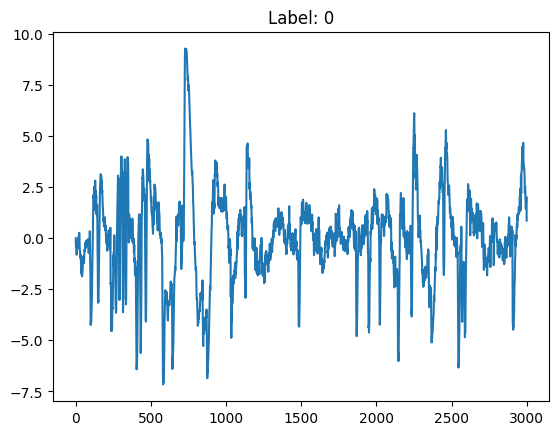

In [59]:
import matplotlib.pyplot as plt
plt.plot(X[0][0])  # First channel of first epoch
plt.title(f"Label: {y[0]}")
plt.show()


In [63]:
# Step 3: Initialize and train model
if 'train_loader' in locals():
    print(f"\nStep 3: Initializing model...")
    model = EEG_Model()
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model initialized:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    print(f"\nStep 4: Starting training...")
    train_loss, train_err, val_loss, val_err = train_CNN(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        batch_size=CONFIG['batch_size'],
        learning_rate=CONFIG['learning_rate'],
        num_epochs=CONFIG['num_epochs'],
        plot_path=CONFIG['plot_path']
    )
    
    print(f"\n✅ Training pipeline completed successfully!")


Step 3: Initializing model...
Model initialized:
  Total parameters: 222,437
  Trainable parameters: 222,437

Step 4: Starting training...
Using device: NVIDIA GeForce RTX 4060
Starting training...
----------------------------------------------------------------------
Epoch  1/75: Train Loss: 1.2957, Train Acc: 0.4447 | Val Loss: 1.1252, Val Acc: 0.5345
Epoch  2/75: Train Loss: 1.0975, Train Acc: 0.5418 | Val Loss: 1.0254, Val Acc: 0.5731
Epoch  3/75: Train Loss: 1.0342, Train Acc: 0.5692 | Val Loss: 0.9259, Val Acc: 0.6149
Epoch  4/75: Train Loss: 1.0198, Train Acc: 0.5689 | Val Loss: 0.9218, Val Acc: 0.6255
Epoch  5/75: Train Loss: 0.9805, Train Acc: 0.5986 | Val Loss: 0.8932, Val Acc: 0.6327
Epoch  6/75: Train Loss: 0.9520, Train Acc: 0.6098 | Val Loss: 0.9024, Val Acc: 0.6152
Epoch  7/75: Train Loss: 0.9545, Train Acc: 0.6043 | Val Loss: 1.0280, Val Acc: 0.5679
Epoch  8/75: Train Loss: 0.9572, Train Acc: 0.6083 | Val Loss: 0.8513, Val Acc: 0.6475
Epoch  9/75: Train Loss: 0.9141, T


Step 5: Plotting training curves...


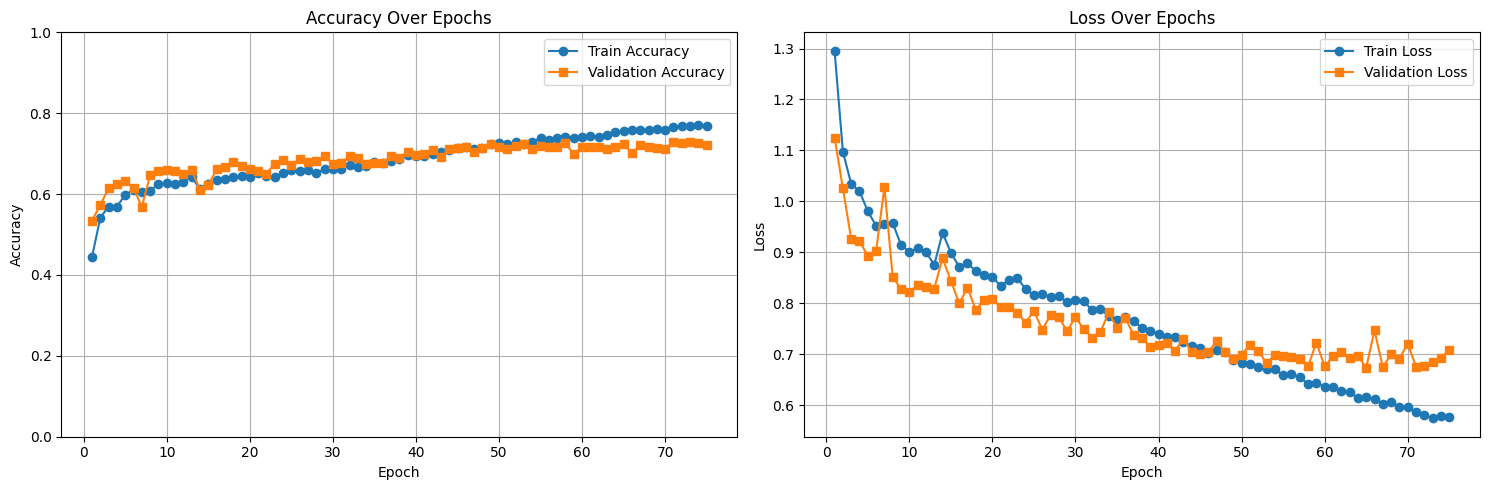

In [64]:
# Step 5: Plot training curves
print(f"\nStep 5: Plotting training curves...")
plot_curve(CONFIG['plot_path'])